<a href="https://colab.research.google.com/github/mindwrapped/pokemon-card-checker/blob/main/pokemon_card_checker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Code for Fine-tuning the Pokemon Card Checker

Huggingface Demo is located [here](https://huggingface.co/spaces/mindwrapped/pokemon-card-checker). Original dataset is located [here](https://www.kaggle.com/datasets/ongshujian/real-and-fake-pokemon-cards).

In [1]:
from IPython.display import clear_output 
!pip install huggingface_hub["fastai"]
!pip install gradio
!pip install wandb
!pip install lime
clear_output()

In [2]:
import os
import numpy as np 
import pandas as pd 
from fastai.callback.wandb import *
from fastai.vision.all import *
import seaborn as sns
import datetime

In [3]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
!mkdir -p data
!unzip -q pk-dataset -d data

In [5]:
# Prep the dataset
# Dataset located here: https://www.kaggle.com/datasets/ongshujian/real-and-fake-pokemon-cards
train_labels_path = 'data/train_labels.csv'
test_labels_path = 'data/test_labels.csv'
path = 'data/'

train_labels = pd.read_csv(train_labels_path)
test_labels = pd.read_csv(test_labels_path)

train_labels['fpath'] = train_labels.id.map(lambda id: f'train/{id}.JPG')
test_labels['fpath'] = test_labels.id.map(lambda id: f'test/{id}.JPG')

fake = test_labels[test_labels['label'] == 0]
fake.head()

,id,label,fpath
0,374,0,test/374.JPG
1,375,0,test/375.JPG
2,376,0,test/376.JPG
3,377,0,test/377.JPG
4,378,0,test/378.JPG


wandb: Currently logged in as: mindwrapped. Use `wandb login --relogin` to force relogin


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

WandbCallback requires use of "SaveModelCallback" to log best model


epoch,train_loss,valid_loss,error_rate,time
0,1.049068,0.402716,0.216216,00:03


epoch,train_loss,valid_loss,error_rate,time
0,0.347535,0.123775,0.040541,00:03
1,0.246231,0.061471,0.027027,00:03
2,0.182012,0.579053,0.175676,00:03
3,0.145271,0.123292,0.067568,00:03
4,0.127717,0.033922,0.013514,00:03


epoch,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_2,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
error_rate,█▂▁▇▃▁
lr_0,▁▂▅█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_1,▁▂▅█▂▂▃▃▄▅▅▅▅▅▄▄▃▃▃▂▂▁▁▁
lr_2,▁▂▅█▂▂▃▃▄▅▅▅▅▅▄▄▃▃▃▂▂▁▁▁
mom_0,█▇▄▂██▆▄▃▁▁▁▁▂▂▃▄▄▅▆▇▇██
mom_1,█▇▄▂██▆▄▃▁▁▁▁▂▂▃▄▄▅▆▇▇██
mom_2,█▇▄▂██▆▄▃▁▁▁▁▂▂▃▄▄▅▆▇▇██


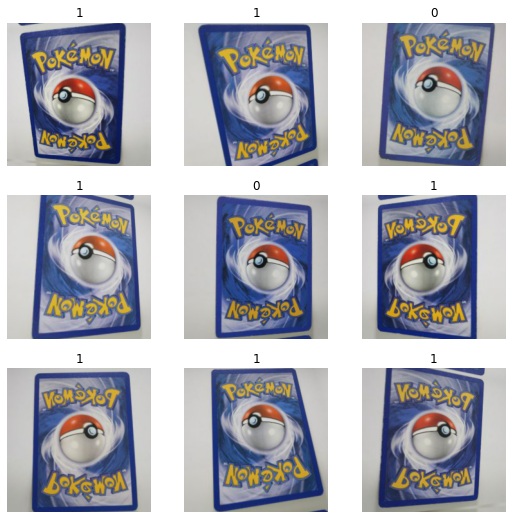

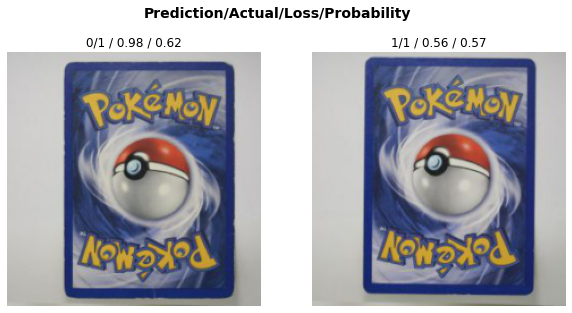

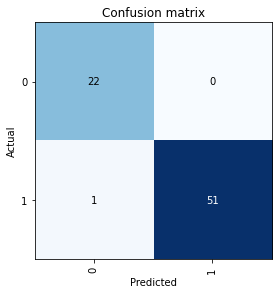

In [6]:
time = datetime.datetime.utcnow().replace(microsecond=0).isoformat()

# Init wandb
run = wandb.init(
    project=f'pokemon-card-checker',
    name=f'pokemon-card-checker-resnet34-{time}',
    config={
        'description': 'resnet34 baseline',
        'image size': 224
    },
)

# Issue with wandb on this..
run.summary['epoch'] = -1

# Create data loader
dls = ImageDataLoaders.from_df(
    train_labels, 
    fn_col='fpath', 
    label_col='label',
    folder=path,
    item_tfms=Resize(400), 
    batch_tfms=aug_transforms(size=224),
)

# Send examples to wandb
dls.show_batch()
plt.savefig('examples.png')
wandb.log({'Image examples': wandb.Image('examples.png')})

# Fine tune resnet34
learn = vision_learner(dls, resnet34, metrics=error_rate, cbs=[WandbCallback()])
learn.fine_tune(5)

# Extra plots
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(2, figsize=(10,5))
plt.savefig('top_losses.png')
wandb.log({'top losses': wandb.Image('top_losses.png')})

interp.plot_confusion_matrix()
plt.savefig('cm.png')
wandb.log({'confusion matrix':wandb.Image('cm.png')})

preds, _ = learn.get_preds(dl=dls.test_dl(test_labels))

run.finish()

In [7]:
label_map = {
    0: 'fake',
    1: 'real'
}

def get_prediction(predictions):
    pred = pd.DataFrame({'id': test_labels['id']})
    for i, label in enumerate(learn.dls.vocab):
      pred[label_map[label]] = predictions[:,i].numpy()

    pred['pred_label'] = pred.apply(lambda x: 1 if x['real'] > x['fake'] else 0, axis=1)
    pred['true_label'] = test_labels.label

    accuracy = (test_labels['label'] == pred['pred_label']).sum() / test_labels.shape[0]
    print(f'Accuracy: {accuracy:.2f}')
    return pred

preds, _ = learn.get_preds(dl=dls.test_dl(test_labels))
pred_no_tta = get_prediction(preds)
pred_no_tta.head()

Accuracy: 0.99


,id,fake,real,pred_label,true_label
0,374,0.996154,3.846342e-03,0,0
1,375,1.000000,1.746284e-10,0,0
2,376,1.000000,4.007196e-08,0,0
3,377,1.000000,2.636582e-07,0,0
4,378,1.000000,6.025702e-11,0,0


In [8]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

explainer = lime_image.LimeImageExplainer()

  0%|          | 0/50 [00:00<?, ?it/s]

Label: 0


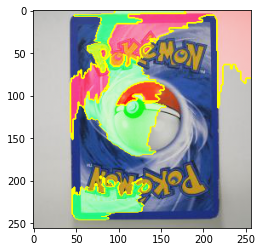

In [14]:
# Used lime here to get more insight into why the model detects certain cards as real or fake
def classify_cards(imgs):
  # print(imgs.shape)
  scores = []

  for i in range(imgs.shape[0]):
    pred_label, _, score = learn.predict(imgs[i])
    scores.append(score.detach().numpy())

  scores = np.array(scores)
  # print(scores.shape)
  return scores

explanation = explainer.explain_instance(
    np.array(Image.open(f'{path}test/401.JPG')), # Fake card
    classifier_fn=classify_cards,
    labels=['fake', 'real'],
    num_samples=50
)

# Display image with mask
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
print(f'Label: {explanation.top_labels[0]}')
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

In [ ]:
# Gradio demo on huggingface spaces -> https://huggingface.co/spaces/mindwrapped/pokemon-card-checker
import numpy as np
import gradio as gr
from huggingface_hub import from_pretrained_fastai
from lime import lime_image
from skimage.segmentation import mark_boundaries

learn = from_pretrained_fastai('mindwrapped/pokemon-card-checker')

def check_card(img):
    pred_label, _, scores = learn.predict(img)
    scores = scores.detach().numpy()
    scores = {'real': float(scores[1]), 'fake': float(scores[0])}

    print(np.array(img).shape)

    # Lime Explanation
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
      np.array(img), 
      classifier_fn=classify_cards,
      labels=['fake', 'real'],
      num_samples=100,
      random_seed=42,
    )
    print(f'top label: {explanation.top_labels[0]}')

    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
    img_boundry = mark_boundaries(temp/255.0, mask)
    return scores, img_boundry

def classify_cards(imgs):
  print(imgs.shape)
  scores = []

  for i in range(imgs.shape[0]):
    pred_label, _, score = learn.predict(imgs[i])
    scores.append(score.detach().numpy())

  scores = np.array(scores)
  print(scores.shape)

  return scores


demo = gr.Interface(
  fn=check_card, 
  inputs='image',
  outputs=["label", "image"],
  examples=['real-1.jpeg','real-2.jpeg','fake-1.jpeg','fake-2.jpeg','real-3.jpeg','real-4.jpeg','fake-3.jpeg','fake-4.jpeg'],
  title='Pokemon Card Checker',
  description='A resnet34 model fine-tuned to determine whether Pokemon cards are real or fake. \n\nAdded [LIME](https://github.com/marcotcr/lime) to show what contributed to the predicted label. \n\n[Dataset](https://www.kaggle.com/datasets/ongshujian/real-and-fake-pokemon-cards) created by [Shujian Ong](https://www.kaggle.com/ongshujian).',
  article='Can you guess which cards are real and fake? \n\nI can\'t :D \n\n([View Labels](https://gist.github.com/mindwrapped/e5aad747757ef006037a1a1982be34fc)) \n\n![visitor badge](https://visitor-badge.glitch.me/badge?page_id=mindwrapped.pokemon-card-checker-space)',
  live=False,
  )

demo.launch(debug=True)